In [ ]:
%%capture
!test -d ./TCC-EEG && rm -r TCC-EEG
%cd /content/
!git clone https://github.com/TheoMoutakanni/TCC-EEG.git
%cd /content/TCC-EEG/
!pip install -U https://api.github.com/repos/braindecode/braindecode/zipball/master

In [28]:
%load_ext autoreload 
%autoreload 1
%aimport models, utils
from importlib import reload
reload(utils.linear)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'utils.linear' from '/home/theo/Documents/TCC-EEG/utils/linear.py'>

In [3]:
from braindecode.util import set_random_seeds
from braindecode.datasets.base import BaseConcatDataset
import matplotlib.pyplot as plt
import numpy as np
import pickle
from skorch.callbacks import EpochScoring, ProgressBar
from skorch.helper import predefined_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch

from utils.datasets import get_sleep_physionet, split_dataset, list_of_train_sets
from utils.skorch import EEGTransformer
from utils.plot import (sleep_cmap, rand_cmap, plot_embeddings, get_ages, get_sleep_stages, get_subjects)
from models.contrastive import ContrastiveModule, EncoderNet, ClassifierNet, train_and_test

# Contrastive Task Training

## Dataset Creation

In [2]:
%%capture
# full dataset, to get a small one, use: get_sleep_physionet(range(10))
windows_dataset, info = get_sleep_physionet()

In [3]:
self_train_set, self_valid_set, full_train_set, valid_set, test_set, subjects_dic = split_dataset(windows_dataset)
print(len(self_train_set), len(self_valid_set), len(full_train_set), len(valid_set), len(test_set))

61817 8203 70020 8290 9865


## Encoder Training

In [4]:
# Encoder
n_channels = 2
p_dropout = 0.2

encoder = EncoderNet(feat_per_layer=[32, 64, 128], n_channels=n_channels, p_dropout=p_dropout, apply_batch_norm=False)
network = ContrastiveModule(encoder)

In [5]:
network = torch.load('contrastive_network.pt')
encoder = network.encoder
with open('contrastive_network.pkl', 'rb') as f:
    skorch_net = pickle.load(f)

EOFError: Ran out of input

In [6]:
#Training
lr = 5e-4
batch_size = 100
max_nb_epochs = 200
early_stopping_patience = 10

skorch_net = network.train_(
    self_train_set, self_valid_set, lr=lr, batch_size=batch_size,
    max_nb_epochs=max_nb_epochs, early_stopping_patience=early_stopping_patience)

  epoch    train_bal_acc    train_loss    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  ---------------  ------------  -------
      1           0.8381        0.3747           0.8234        0.3932  45.1096


      2           0.8350        0.3765           0.8187        0.4009  45.6524


In [36]:
torch.save(network, 'contrastive_network.pt')

In [7]:
with open('contrastive_network.pkl', 'wb') as f:
    pickle.dump(skorch_net, f)

## Predictions

In [8]:
# Embeddings
embds = skorch_net.transform(self_valid_set)[::2]
# PCA
pca = PCA(2)
pca_embds = pca.fit_transform(embds)
# TSNE
tsne = TSNE(2, n_jobs=-1)
tsne_embds = tsne.fit_transform(embds)

In [18]:
print('Explained variance (%) for PCA with 2 components: ', pca.explained_variance_ratio_.sum())

Explained variance (%) for PCA with 2 components:  0.7088891


# Plots

In [9]:
sleep_stages = get_sleep_stages(self_valid_set)
ages = get_ages(self_valid_set, info)
subjects = get_subjects(self_valid_set)

In [10]:
new_cmap = rand_cmap(max(subjects)+1, type='bright', first_color_black=True,
                     last_color_black=False, verbose=False)
mapping = {  # We merge stages 3 and 4 following AASM standards.
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,
    'Sleep stage R': 4
}
reverse_mapping = {v: k[-1] for k,v in mapping.items()}

## Sleep Stages

Text(0.5, 1.0, 'PCA of self-supervised embeddings according to sleep stages')

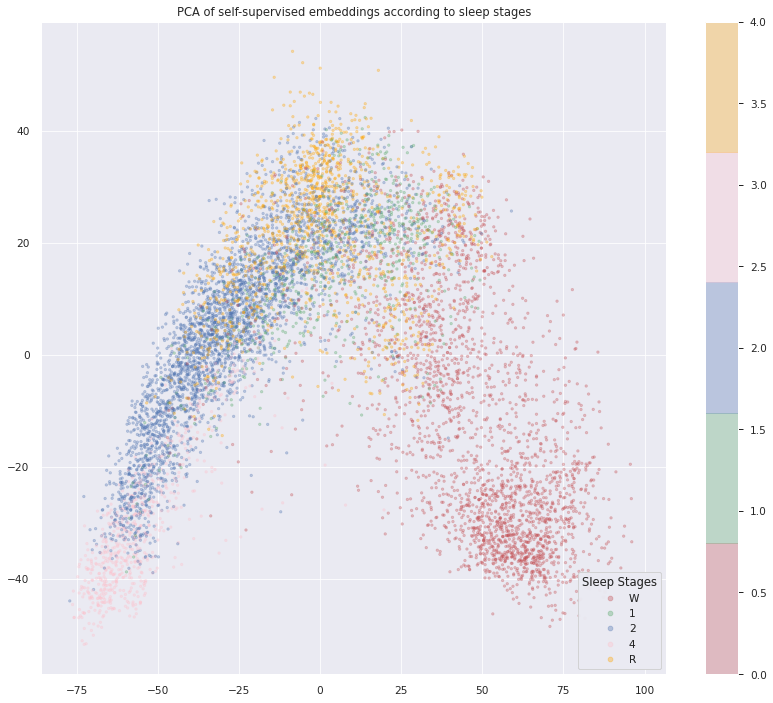

In [11]:
plot_embeddings(pca_embds, sleep_stages, sleep_cmap, legend_dict={'title': 'Sleep Stages', 'color_mapping': reverse_mapping})
plt.title("PCA of self-supervised embeddings according to sleep stages")

Text(0.5, 1.0, 'TSNE of self-supervised embeddings according to sleep stages')

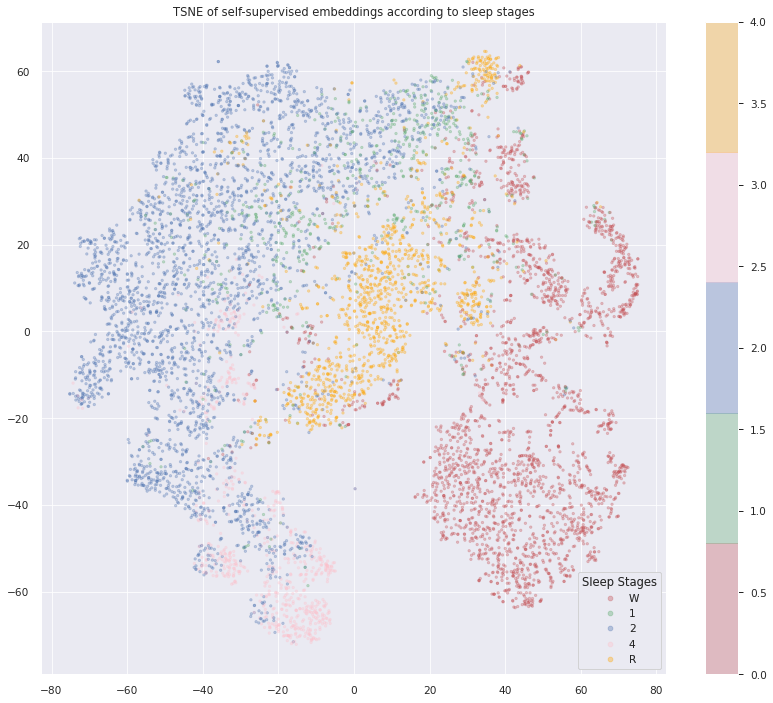

In [12]:
plot_embeddings(tsne_embds, sleep_stages, sleep_cmap, legend_dict={'title': 'Sleep Stages', 'color_mapping': reverse_mapping})
plt.title("TSNE of self-supervised embeddings according to sleep stages")

## Age

Text(0.5, 1.0, 'PCA of self-supervised embeddings according to age')

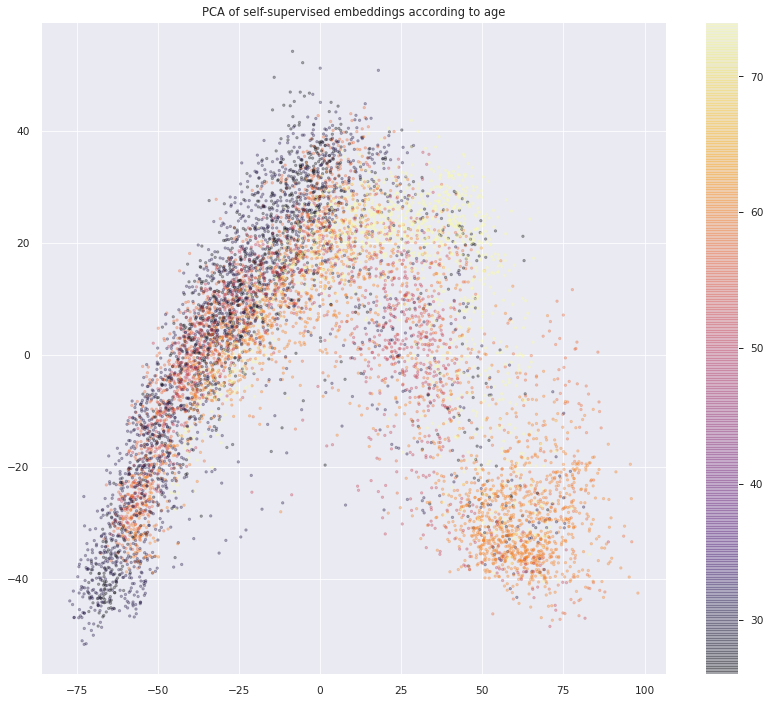

In [19]:
plot_embeddings(pca_embds, ages, plt.get_cmap('inferno'))
plt.title('PCA of self-supervised embeddings according to age')

Text(0.5, 1.0, 'TSNE of self-supervised embeddings according to age')

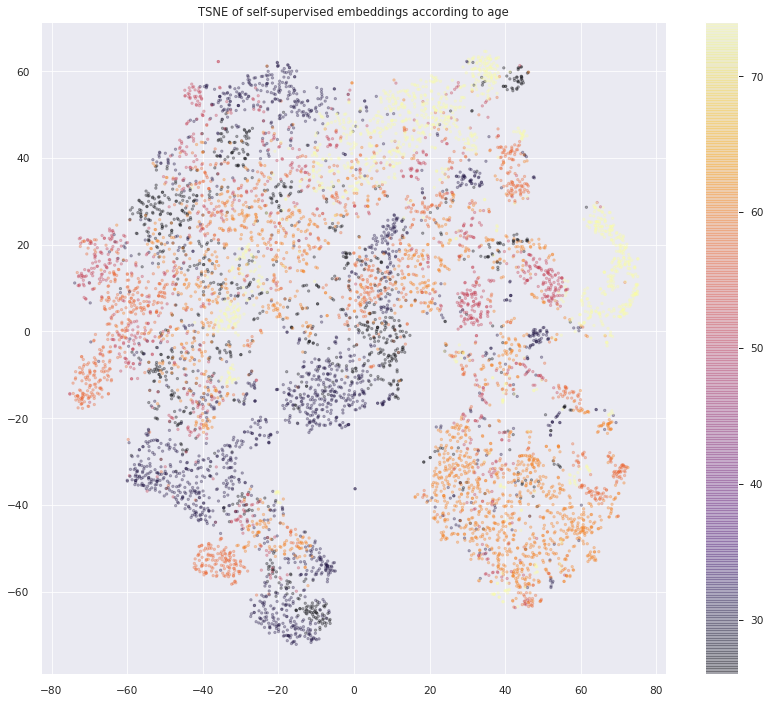

In [20]:
plot_embeddings(tsne_embds, ages, plt.get_cmap('inferno'))
plt.title('TSNE of self-supervised embeddings according to age')

## Patient ID

Text(0.5, 1.0, 'PCA of self-supervised embeddings according to patient id')

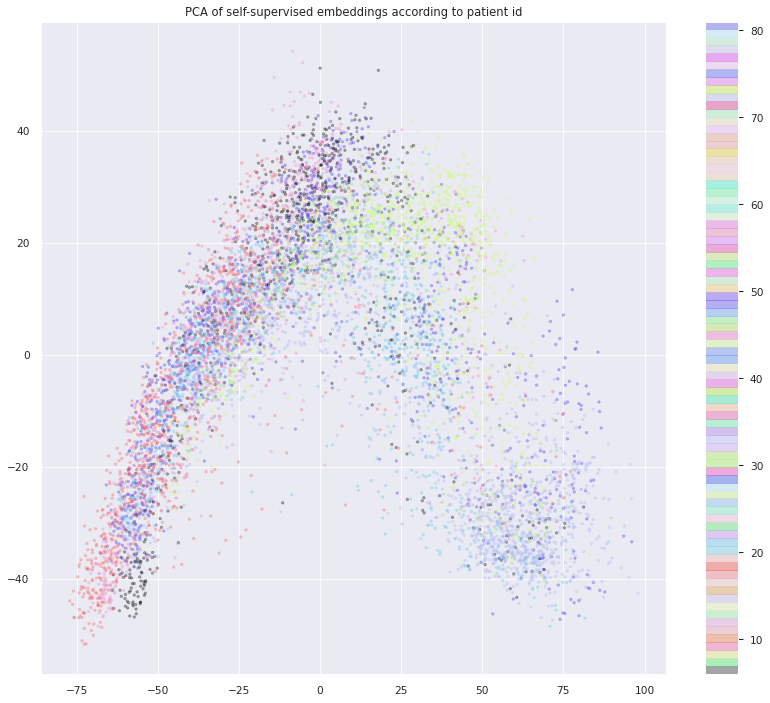

In [21]:
plot_embeddings(pca_embds, subjects, new_cmap)
plt.title('PCA of self-supervised embeddings according to patient id')

Text(0.5, 1.0, 'TSNE of self-supervised embeddings according to patient id')

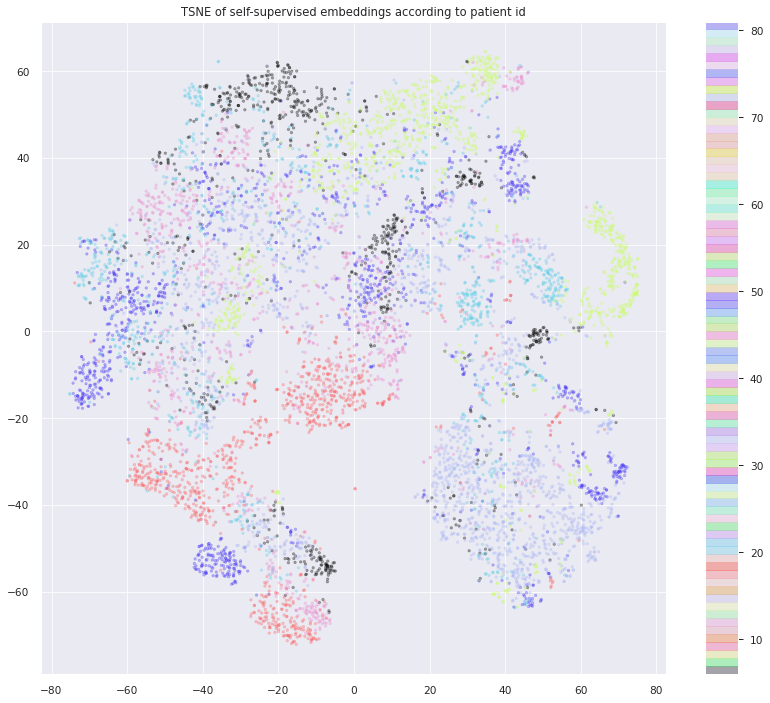

In [22]:
plot_embeddings(tsne_embds, subjects, new_cmap)
plt.title('TSNE of self-supervised embeddings according to patient id')

Text(0.5, 1.0, 'Accuracy when detecting the subject of 30s window for a KNN classifier trained on a fraction of the data')

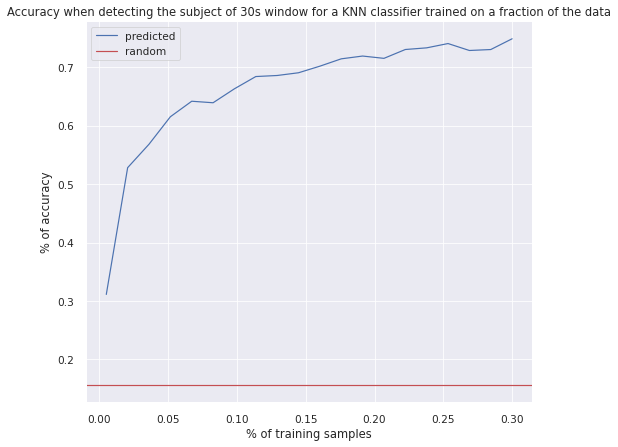

In [29]:
from utils.linear import plot_knn

plot_knn([embds], subjects, ['predicted'])
plt.title('Accuracy when detecting the subject of 30s window for a KNN classifier trained on a fraction of the data')

# Downstream task

In [30]:
train_sets = list_of_train_sets(subjects_dic["full_train_subjects"], windows_dataset)

In [33]:
lr = 5e-4
batch_size = 64
max_nb_epochs = 100
early_stopping_patience = 10

acc_list = []
for train_set in train_sets[::5]:
    classifier_net = ClassifierNet(encoder, p_dropout=0.2)
    _, acc = train_and_test(classifier_net, train_set, valid_set, test_set=test_set, lr=lr, batch_size=batch_size,
                            max_nb_epochs=max_nb_epochs, early_stopping_patience=early_stopping_patience, train_what="last")
    acc_list.append(acc)

  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss     dur
-------  ---------------  ------------  -----------  ---------------  ------------  ------
      1           0.2107        1.3998       0.3918           0.2000        1.5107  0.9827


      2           0.2263        1.3398       0.4141           0.3333        1.4911  0.9303


      3           0.3277        1.2937       0.4205           0.3265        1.4824  0.9528


      4           0.3259        1.2860       0.4160           0.3322        1.4886  0.9383


      5           0.3347        1.2811       0.4182           0.3324        1.4866  0.9263


      6           0.3317        1.2806       0.4127           0.3339        1.4908  0.9167


      7           0.3297        1.2833       0.4194           0.3281        1.4836  0.9099


      8           0.3197        1.2813       0.4099           0.3342        1.4931  0.9373


      9           0.3455        1.2806       0.4164           0.3315        1.4875  0.9510


     10           0.3402        1.2744       0.4111           0.3337        1.4909  0.9670


     11           0.3344        1.2789       0.4159           0.3330        1.4853  0.9296


     12           0.3445        1.2691       0.4156           0.3347        1.4844  0.9424


     13           0.3383        1.2736       0.4165           0.3339        1.4830  0.9341


     14           0.3363        1.2730       0.4150           0.3348        1.4833  0.9206


     15           0.3476        1.2664       0.4090           0.3372        1.4862  0.9487


     16           0.3468        1.2664       0.4119           0.3367        1.4830  0.9404


     17           0.3417        1.2710       0.4062           0.3381        1.4878  0.9318


     18           0.3483        1.2698       0.4140           0.3361        1.4813  0.9631


     19           0.3434        1.2676       0.4123           0.3369        1.4826  0.9729


     20           0.3375        1.2676       0.4151           0.3340        1.4788  0.9683


     21           0.3448        1.2689       0.4021           0.3377        1.4910  0.9368


     22           0.3429        1.2701       0.4075           0.3353        1.4868  0.9739


     23           0.4083        1.2321       0.6441           0.5113        1.2620  0.9938


     24           0.5227        1.1542       0.6203           0.4932        1.2816  0.9746


     25           0.5398        1.1464       0.6297           0.5068        1.2713  0.9890


     26           0.5310        1.1517       0.6258           0.4996        1.2757  0.9634


     27           0.5169        1.1537       0.6273           0.5008        1.2740  0.9487


     28           0.5478        1.1467       0.6329           0.4998        1.2696  0.9559


     29           0.5343        1.1463       0.6409           0.5062        1.2627  0.9209


     30           0.5379        1.1457       0.6422           0.5116        1.2598  0.9690


     31           0.5399        1.1421       0.6479           0.5119        1.2533  0.9872


     32           0.5323        1.1470       0.6416           0.5033        1.2606  0.9991


     33           0.5232        1.1563       0.6443           0.5155        1.2587  0.9913


     34           0.5325        1.1422       0.6449           0.5047        1.2583  0.9721


     35           0.5442        1.1379       0.6421           0.5088        1.2614  0.9690


     36           0.5414        1.1406       0.6493           0.5091        1.2522  1.0024


     37           0.5334        1.1473       0.6438           0.5129        1.2586  0.9890


     38           0.5427        1.1432       0.6351           0.5060        1.2669  0.9864


     39           0.5365        1.1443       0.6409           0.5099        1.2626  0.9759


     40           0.5366        1.1418       0.6520           0.5159        1.2503  1.0012


     41           0.5316        1.1510       0.6339           0.4895        1.2676  1.0091


     42           0.5325        1.1469       0.6441           0.5104        1.2576  0.9886


     43           0.5436        1.1406       0.6400           0.5082        1.2630  1.0157


     44           0.5388        1.1415       0.6460           0.5101        1.2566  1.0414


     45           0.5296        1.1453       0.6458           0.5127        1.2563  0.9967


     46           0.5366        1.1449       0.6224           0.4863        1.2790  0.9979


     47           0.5326        1.1462       0.6414           0.5119        1.2612  1.0121


     48           0.5494        1.1414       0.6513           0.5075        1.2493  0.9893


     49           0.5455        1.1397       0.6407           0.5174        1.2605  0.9965


     50           0.5403        1.1427       0.6450           0.5100        1.2590  1.0141


     51           0.5393        1.1438       0.6415           0.5178        1.2596  1.0234


     52           0.5403        1.1466       0.6407           0.4996        1.2616  1.0371


     53           0.5333        1.1415       0.6399           0.5126        1.2623  1.0455


     54           0.5386        1.1424       0.6510           0.5185        1.2519  1.0070


     55           0.5463        1.1421       0.6434           0.5053        1.2591  1.0713


     56           0.5387        1.1420       0.6467           0.5190        1.2555  1.0619


     57           0.5500        1.1387       0.6469           0.5146        1.2566  1.0758


     58           0.5430        1.1375       0.6473           0.5145        1.2555  1.0775


     59           0.5345        1.1458       0.6496           0.5118        1.2528  0.9962


     60           0.5461        1.1392       0.6503           0.5176        1.2514  0.9753


     61           0.5366        1.1416       0.6503           0.5089        1.2505  1.0103


     62           0.5354        1.1420       0.6533           0.5196        1.2496  1.0114


     63           0.5466        1.1418       0.6399           0.5122        1.2638  0.9268


     64           0.5443        1.1436       0.6516           0.5098        1.2498  1.0283


     65           0.5302        1.1471       0.6492           0.5228        1.2543  0.9817


     66           0.5555        1.1301       0.6519           0.5100        1.2497  0.9990


     67           0.5338        1.1424       0.6520           0.5139        1.2496  1.1090


     68           0.5411        1.1397       0.6569           0.5151        1.2447  1.0143


     69           0.5403        1.1459       0.6484           0.5182        1.2547  0.9948


     70           0.5419        1.1399       0.6415           0.5031        1.2614  0.9814


     71           0.5285        1.1465       0.6517           0.5153        1.2500  0.9868


     72           0.5444        1.1409       0.6479           0.5218        1.2554  1.0195


     73           0.5417        1.1439       0.6396           0.5081        1.2637  0.9912


     74           0.5470        1.1349       0.6532           0.5213        1.2497  0.9925


Stopping since valid_bal_acc has not improved in the last 10 epochs.


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss     dur
-------  ---------------  ------------  -----------  ---------------  ------------  ------
      1           0.3935        1.2382       0.6724           0.5081        1.2310  1.7256


      2           0.4602        1.1863       0.6698           0.5084        1.2305  1.6808


      3           0.4564        1.1856       0.6673           0.5119        1.2329  1.6980


      4           0.4658        1.1832       0.6671           0.5103        1.2336  1.7695


      5           0.4682        1.1803       0.6695           0.5088        1.2322  1.7351


      6           0.4757        1.1773       0.6724           0.5148        1.2283  1.5963


      7           0.4679        1.1798       0.6671           0.5206        1.2339  1.7165


      8           0.4839        1.1768       0.6700           0.5131        1.2308  1.6938


      9           0.4822        1.1742       0.6674           0.5259        1.2359  1.7216


     10           0.4830        1.1763       0.6733           0.5103        1.2287  1.7029


     11           0.4750        1.1787       0.6768           0.5067        1.2242  1.7131


     12           0.4700        1.1790       0.6719           0.5181        1.2286  1.7343


     13           0.4742        1.1760       0.6731           0.5161        1.2273  1.6969


     14           0.4830        1.1730       0.6709           0.5211        1.2311  1.7940


     15           0.4735        1.1746       0.6590           0.5304        1.2427  1.8208


     16           0.4799        1.1764       0.6663           0.5134        1.2355  1.8435


     17           0.4835        1.1712       0.6645           0.5321        1.2379  1.8624


     18           0.4886        1.1722       0.6777           0.5005        1.2265  1.8113


     19           0.4757        1.1736       0.6779           0.5153        1.2237  1.8614


     20           0.4820        1.1732       0.6702           0.5294        1.2326  1.6477


     21           0.4785        1.1745       0.6678           0.5202        1.2331  1.7107


     22           0.4785        1.1740       0.6720           0.5200        1.2294  1.8550


     23           0.4811        1.1758       0.6653           0.5321        1.2375  1.8557


     24           0.4879        1.1729       0.6738           0.5252        1.2277  1.7331


     25           0.4781        1.1733       0.6659           0.5299        1.2346  1.8033


     26           0.4759        1.1745       0.6761           0.5206        1.2253  1.8054


Stopping since valid_bal_acc has not improved in the last 10 epochs.


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss     dur
-------  ---------------  ------------  -----------  ---------------  ------------  ------
      1           0.3727        1.2157       0.6134           0.3696        1.2906  2.8193


      2           0.3816        1.1988       0.6265           0.3799        1.2778  2.8655


      3           0.3838        1.1955       0.6310           0.3836        1.2718  2.7909


      4           0.3845        1.1938       0.6303           0.3830        1.2729  2.7932


      5           0.3852        1.1925       0.6357           0.3873        1.2676  2.8804


      6           0.3850        1.1934       0.6318           0.3844        1.2706  2.9168


      7           0.3842        1.1940       0.6317           0.3841        1.2701  2.8738


      8           0.4428        1.1687       0.6525           0.4263        1.2481  2.9944


      9           0.5003        1.1397       0.6882           0.4707        1.2128  2.9012


     10           0.5060        1.1369       0.6568           0.4245        1.2445  2.8349


     11           0.5065        1.1357       0.6608           0.4285        1.2397  2.8713


     12           0.5105        1.1320       0.6903           0.4743        1.2104  2.8181


     13           0.5121        1.1316       0.7127           0.5086        1.1901  2.8052


     14           0.5076        1.1348       0.6793           0.4586        1.2212  2.8735


     15           0.5165        1.1300       0.6932           0.4811        1.2065  2.8350


     16           0.5148        1.1324       0.6912           0.4786        1.2081  2.8117


     17           0.5160        1.1320       0.6954           0.4823        1.2039  2.6705


     18           0.5131        1.1321       0.6972           0.4946        1.2025  2.7474


     19           0.5200        1.1288       0.6938           0.4905        1.2077  2.7341


     20           0.5211        1.1292       0.7054           0.5046        1.1959  2.8329


     21           0.5310        1.1245       0.7018           0.4936        1.1994  2.7034


     22           0.5235        1.1285       0.6745           0.4563        1.2256  2.7955


Stopping since valid_bal_acc has not improved in the last 10 epochs.


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss     dur
-------  ---------------  ------------  -----------  ---------------  ------------  ------
      1           0.3385        1.4342       0.4544           0.2989        1.4301  3.6867


      2           0.3782        1.4067       0.4843           0.3492        1.4030  3.5499


      3           0.4575        1.2704       0.6996           0.5878        1.1983  3.6785


      4           0.5939        1.1471       0.7037           0.5883        1.1944  3.8534


      5           0.6172        1.1416       0.7160           0.5773        1.1825  3.8860


      6           0.6142        1.1397       0.7367           0.6341        1.1647  3.8655


      7           0.6125        1.1394       0.7247           0.6077        1.1741  3.7309


      8           0.6175        1.1352       0.7265           0.6138        1.1724  3.6918


      9           0.6307        1.1342       0.7361           0.6463        1.1641  3.7538


     10           0.6324        1.1324       0.7400           0.6354        1.1600  3.9401


     11           0.6326        1.1337       0.7095           0.5967        1.1903  3.7962


     12           0.6321        1.1296       0.7181           0.6090        1.1795  3.6928


     13           0.6442        1.1264       0.7466           0.6307        1.1521  3.7460


     14           0.6345        1.1296       0.7294           0.5967        1.1712  3.7655


     15           0.6391        1.1281       0.7473           0.6242        1.1519  4.0643


     16           0.6355        1.1280       0.7484           0.6470        1.1511  3.8387


     17           0.6378        1.1287       0.7657           0.6853        1.1374  3.7336


     18           0.6475        1.1254       0.7522           0.6476        1.1475  3.8722


     19           0.6499        1.1242       0.7645           0.6606        1.1368  3.9346


     20           0.6355        1.1288       0.7464           0.6355        1.1525  4.0009


     21           0.6437        1.1273       0.7410           0.6288        1.1591  4.0775


     22           0.6474        1.1253       0.7359           0.6453        1.1646  4.0859


     23           0.6541        1.1231       0.7251           0.6155        1.1726  4.0386


     24           0.6438        1.1251       0.7335           0.6180        1.1641  4.1146


     25           0.6373        1.1287       0.7331           0.6250        1.1675  3.8557


     26           0.6500        1.1222       0.7425           0.6374        1.1577  3.8450


Stopping since valid_bal_acc has not improved in the last 10 epochs.


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss     dur
-------  ---------------  ------------  -----------  ---------------  ------------  ------
      1           0.4943        1.2089       0.6546           0.5217        1.2461  4.8469


      2           0.5114        1.1973       0.6620           0.5210        1.2409  5.2228


      3           0.6220        1.1456       0.7004           0.5650        1.1975  5.0800


      4           0.6437        1.1329       0.7197           0.6092        1.1794  4.9373


      5           0.6427        1.1326       0.7151           0.6042        1.1836  4.8379


      6           0.6453        1.1315       0.7321           0.6346        1.1684  4.8527


      7           0.6494        1.1283       0.7403           0.6463        1.1611  5.1446


      8           0.6486        1.1308       0.7297           0.6140        1.1696  4.9145


      9           0.6453        1.1287       0.7116           0.6124        1.1880  4.5675


     10           0.6500        1.1276       0.7268           0.6281        1.1739  4.9156


     11           0.6453        1.1294       0.7515           0.6445        1.1500  4.9354


     12           0.6469        1.1271       0.7402           0.6368        1.1619  4.6851


     13           0.6488        1.1274       0.7388           0.6473        1.1631  4.9378


     14           0.6543        1.1258       0.7203           0.6182        1.1792  4.8486


     15           0.6523        1.1249       0.7251           0.6093        1.1736  5.0217


     16           0.6556        1.1232       0.7567           0.6769        1.1422  4.4463


     17           0.6636        1.1233       0.7538           0.6633        1.1479  4.9102


     18           0.6667        1.1209       0.7344           0.6550        1.1637  4.5684


     19           0.6648        1.1207       0.7461           0.6464        1.1552  4.7764


     20           0.6699        1.1178       0.7537           0.6761        1.1473  4.7163


     21           0.6737        1.1189       0.7566           0.6680        1.1467  5.0202


     22           0.6758        1.1163       0.7417           0.6398        1.1579  4.8119


     23           0.6765        1.1164       0.7422           0.6279        1.1564  4.9668


     24           0.6710        1.1179       0.7676           0.6769        1.1363  4.7178


     25           0.6751        1.1188       0.7519           0.6592        1.1487  4.4539


Stopping since valid_bal_acc has not improved in the last 10 epochs.


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss     dur
-------  ---------------  ------------  -----------  ---------------  ------------  ------
      1           0.5679        1.1903       0.7334           0.6130        1.1641  5.6760


      2           0.6241        1.1433       0.7128           0.6125        1.1866  5.7056


      3           0.6287        1.1413       0.7158           0.5946        1.1830  5.6363


      4           0.6271        1.1409       0.7093           0.6057        1.1894  5.8182


      5           0.6320        1.1372       0.7388           0.6446        1.1627  6.1886


      6           0.6356        1.1378       0.7288           0.6058        1.1702  5.8129


      7           0.6411        1.1331       0.7548           0.6572        1.1432  6.3715


      8           0.6505        1.1312       0.7421           0.6555        1.1574  6.3309


      9           0.6486        1.1300       0.7487           0.6703        1.1510  6.0501


     10           0.6515        1.1321       0.7267           0.6286        1.1743  5.6336


     11           0.6539        1.1289       0.7402           0.6608        1.1576  5.8456


     12           0.6548        1.1295       0.7396           0.6536        1.1593  5.6635


     13           0.6562        1.1260       0.7422           0.6593        1.1562  5.5867


     14           0.6548        1.1270       0.7366           0.6274        1.1618  5.7435


     15           0.6566        1.1269       0.7468           0.6536        1.1556  5.9734


     16           0.6586        1.1268       0.7397           0.6357        1.1594  5.9095


     17           0.6612        1.1240       0.7388           0.6303        1.1593  5.6674


     18           0.6595        1.1241       0.7358           0.6388        1.1643  5.6633


Stopping since valid_bal_acc has not improved in the last 10 epochs.


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss     dur
-------  ---------------  ------------  -----------  ---------------  ------------  ------
      1           0.4785        1.1950       0.7148           0.5101        1.1878  6.6543


      2           0.4985        1.1768       0.6972           0.4862        1.2017  6.7076


      3           0.5008        1.1752       0.7113           0.5041        1.1904  6.3763


      4           0.4996        1.1741       0.7154           0.5109        1.1867  6.4724


      5           0.5121        1.1702       0.6922           0.4752        1.2082  6.3488


      6           0.5130        1.1682       0.7131           0.5124        1.1868  6.3519


      7           0.5124        1.1680       0.7113           0.5090        1.1894  6.5549


      8           0.5200        1.1661       0.6814           0.4642        1.2196  6.5281


      9           0.5213        1.1639       0.7160           0.5228        1.1846  6.3668


     10           0.5224        1.1636       0.7271           0.5394        1.1776  6.2770


     11           0.5173        1.1662       0.6890           0.4744        1.2086  6.4961


     12           0.5210        1.1637       0.6937           0.4857        1.2063  6.4490


     13           0.5181        1.1642       0.7023           0.4967        1.1961  6.4943


     14           0.5234        1.1623       0.7053           0.5111        1.1931  6.5322


     15           0.5247        1.1631       0.7017           0.4960        1.1974  6.5603


     16           0.5257        1.1606       0.7239           0.5360        1.1773  6.3943


     17           0.5257        1.1615       0.7068           0.5048        1.1937  6.4799


     18           0.5289        1.1604       0.7145           0.5240        1.1862  6.3396


     19           0.5266        1.1607       0.7088           0.5113        1.1907  6.5701


Stopping since valid_bal_acc has not improved in the last 10 epochs.


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss     dur
-------  ---------------  ------------  -----------  ---------------  ------------  ------
      1           0.5644        1.1912       0.7476           0.6552        1.1541  7.1885


      2           0.6142        1.1500       0.7641           0.6730        1.1388  7.3696


      3           0.6171        1.1474       0.7556           0.6672        1.1481  7.7889


      4           0.6200        1.1459       0.7511           0.6665        1.1498  7.5534


      5           0.6250        1.1438       0.7271           0.6329        1.1700  7.4665


      6           0.6352        1.1394       0.7450           0.6724        1.1526  7.2053


      7           0.6333        1.1416       0.7393           0.6592        1.1575  7.2166


      8           0.6409        1.1385       0.7490           0.6604        1.1500  7.3478


      9           0.6379        1.1374       0.7613           0.6701        1.1388  7.4457


     10           0.6387        1.1372       0.7520           0.6785        1.1464  7.1416


     11           0.6443        1.1363       0.7616           0.6676        1.1385  7.3384


     12           0.6408        1.1365       0.7499           0.6683        1.1496  7.2347


     13           0.6431        1.1348       0.7520           0.6629        1.1464  7.2393


     14           0.6481        1.1334       0.7511           0.6762        1.1500  7.4336


     15           0.6464        1.1328       0.7490           0.6587        1.1512  7.3258


     16           0.6502        1.1316       0.7310           0.6384        1.1636  7.2275


     17           0.6475        1.1337       0.7358           0.6215        1.1624  7.2655


     18           0.6429        1.1330       0.7589           0.6702        1.1402  7.6797


     19           0.6486        1.1311       0.7556           0.6588        1.1433  7.8597


Stopping since valid_bal_acc has not improved in the last 10 epochs.


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss     dur
-------  ---------------  ------------  -----------  ---------------  ------------  ------
      1           0.3857        1.2448       0.6923           0.4777        1.2066  8.0202


      2           0.4997        1.1822       0.6957           0.4869        1.2043  8.3553


      3           0.5062        1.1769       0.7232           0.5257        1.1808  8.2269


      4           0.5103        1.1766       0.7185           0.5183        1.1810  8.1845


      5           0.5182        1.1731       0.7031           0.5003        1.1972  8.4414


      6           0.5205        1.1709       0.7139           0.5146        1.1859  8.4531


      7           0.5247        1.1687       0.7051           0.5006        1.1943  8.6033


      8           0.5264        1.1682       0.7194           0.5277        1.1796  8.4709


      9           0.5226        1.1703       0.7107           0.5167        1.1906  8.0268


     10           0.5255        1.1679       0.7211           0.5288        1.1792  8.2367


     11           0.5266        1.1679       0.7158           0.5198        1.1842  8.2591


     12           0.5268        1.1679       0.7088           0.5057        1.1899  8.1219


     13           0.5278        1.1671       0.7129           0.5158        1.1876  7.8143


     14           0.5282        1.1665       0.7104           0.5245        1.1869  7.9750


     15           0.5321        1.1661       0.7041           0.5111        1.1955  7.8852


     16           0.5273        1.1670       0.7128           0.5193        1.1870  7.9560


     17           0.5341        1.1634       0.7181           0.5263        1.1814  7.9287


     18           0.5322        1.1640       0.7174           0.5273        1.1836  8.0102


     19           0.5344        1.1626       0.7086           0.5146        1.1893  7.9350


Stopping since valid_bal_acc has not improved in the last 10 epochs.


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss     dur
-------  ---------------  ------------  -----------  ---------------  ------------  ------
      1           0.5925        1.1709       0.7511           0.6622        1.1504  8.9329


      2           0.6183        1.1536       0.7420           0.6253        1.1570  9.4697


      3           0.6225        1.1510       0.7604           0.6779        1.1420  9.0204


      4           0.6259        1.1498       0.7577           0.6550        1.1438  8.9733


      5           0.6296        1.1462       0.7413           0.6384        1.1561  9.2365


      6           0.6382        1.1444       0.7527           0.6634        1.1456  10.0233


      7           0.6445        1.1410       0.7405           0.6518        1.1592  9.5694


      8           0.6470        1.1413       0.7661           0.6713        1.1330  9.4931


      9           0.6480        1.1393       0.7610           0.6849        1.1414  9.2586


     10           0.6498        1.1382       0.7575           0.6582        1.1446  8.7232


     11           0.6478        1.1385       0.7538           0.6629        1.1456  8.3312


     12           0.6484        1.1359       0.7357           0.6385        1.1610  8.4378


     13           0.6493        1.1372       0.7431           0.6507        1.1563  8.2025


     14           0.6556        1.1353       0.7539           0.6695        1.1436  8.0173


     15           0.6593        1.1338       0.7337           0.6458        1.1638  8.1328


     16           0.6600        1.1334       0.7452           0.6409        1.1520  7.9573


     17           0.6545        1.1345       0.7560           0.6539        1.1428  7.9406


     18           0.6542        1.1336       0.7614           0.6835        1.1377  8.5449


Stopping since valid_bal_acc has not improved in the last 10 epochs.


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss     dur
-------  ---------------  ------------  -----------  ---------------  ------------  ------
      1           0.4151        1.2311       0.6971           0.4809        1.2017  8.7032


      2           0.5059        1.1810       0.7097           0.5043        1.1932  8.8590


      3           0.5105        1.1784       0.7163           0.5353        1.1832  9.0183


      4           0.5203        1.1737       0.7217           0.5291        1.1813  9.1322


      5           0.5229        1.1725       0.7210           0.5343        1.1811  8.7152


      6           0.5241        1.1721       0.7281           0.5359        1.1743  8.9730


      7           0.5250        1.1723       0.7218           0.5392        1.1790  8.9076


      8           0.5264        1.1710       0.7252           0.5373        1.1756  8.8356


      9           0.5279        1.1692       0.7134           0.5313        1.1883  8.5866


     10           0.5304        1.1684       0.7017           0.5077        1.1966  8.6483


     11           0.5313        1.1675       0.7086           0.5134        1.1903  8.8047


     12           0.5285        1.1683       0.7185           0.5352        1.1843  9.2902


     13           0.5313        1.1669       0.7107           0.5158        1.1876  9.0195


     14           0.5337        1.1665       0.7253           0.5480        1.1755  9.0261


     15           0.5346        1.1646       0.7270           0.5411        1.1757  8.6444


     16           0.5361        1.1647       0.7317           0.5507        1.1718  8.8990


     17           0.5344        1.1646       0.7089           0.5167        1.1911  9.1800


     18           0.5364        1.1634       0.7189           0.5261        1.1830  8.9888


     19           0.5369        1.1627       0.7195           0.5343        1.1796  8.6062


     20           0.5373        1.1616       0.6894           0.4878        1.2048  8.9037


     21           0.5405        1.1608       0.7347           0.5557        1.1669  9.0294


     22           0.5409        1.1602       0.7144           0.5318        1.1828  8.8809


     23           0.5409        1.1596       0.7106           0.5226        1.1861  8.7032


     24           0.5439        1.1587       0.7253           0.5365        1.1754  8.8739


     25           0.5425        1.1584       0.7258           0.5446        1.1739  8.8995


     26           0.5436        1.1584       0.7228           0.5411        1.1766  8.8663


     27           0.5456        1.1570       0.7138           0.5237        1.1852  8.8545


     28           0.5436        1.1583       0.7123           0.5223        1.1850  8.9257


     29           0.5452        1.1565       0.7135           0.5332        1.1844  8.5974


     30           0.5459        1.1562       0.7210           0.5426        1.1770  8.5963


Stopping since valid_bal_acc has not improved in the last 10 epochs.


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss     dur
-------  ---------------  ------------  -----------  ---------------  ------------  ------
      1           0.4078        1.2347       0.6934           0.4822        1.2059  9.6312


      2           0.5051        1.1795       0.7168           0.5164        1.1861  10.3020


      3           0.5158        1.1749       0.7138           0.5144        1.1873  10.0245


      4           0.5194        1.1726       0.7191           0.5259        1.1825  10.0564


      5           0.5189        1.1720       0.7314           0.5496        1.1723  10.2834


      6           0.5244        1.1695       0.7321           0.5435        1.1704  9.9831


      7           0.5257        1.1685       0.7189           0.5285        1.1826  10.1673


      8           0.5279        1.1676       0.7226           0.5373        1.1807  10.0418


      9           0.5299        1.1668       0.7321           0.5492        1.1718  10.1536


     10           0.5289        1.1666       0.7207           0.5348        1.1821  9.9986


     11           0.5314        1.1648       0.7181           0.5263        1.1827  10.0559


     12           0.5325        1.1641       0.7399           0.5605        1.1640  10.1539


     13           0.5311        1.1648       0.7171           0.5225        1.1824  10.2248


     14           0.5355        1.1628       0.7300           0.5443        1.1734  10.1988


     15           0.5363        1.1622       0.7248           0.5431        1.1780  10.0172


     16           0.5353        1.1623       0.7256           0.5364        1.1761  10.2492


     17           0.5361        1.1616       0.7241           0.5403        1.1748  10.5620


     18           0.5359        1.1613       0.7201           0.5381        1.1788  11.7277


     19           0.5377        1.1604       0.7250           0.5385        1.1755  11.2468


     20           0.5368        1.1601       0.7163           0.5387        1.1820  10.1932


     21           0.5410        1.1584       0.7042           0.5103        1.1926  10.5940


Stopping since valid_bal_acc has not improved in the last 10 epochs.


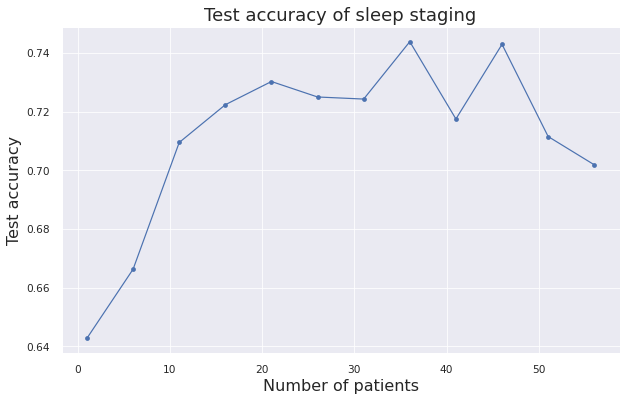

In [34]:
nb_patients = [(1 + i*5) for i in range(len(subjects_dic["full_train_subjects"][::5]))]
nb_windows = [len(train_set) for train_set in train_sets[::5]]


# To add the number of windows
# fig, ax1 = plt.subplots(figsize=(10,6))
# ax1.plot(nb_patients, acc, marker="o");
# ax1.set_xlabel('Number of patients', fontsize=16)
# ax1.set_ylabel('Test accuracy', fontsize=16)
# ax1.set_title('Test accuracy of sleep staging', fontsize=18)
# ax2 = ax1.secondary_xaxis('top')
# ax2.set_xlabel('Number of windows', fontsize=16)
# ax2.set_xticklabels(nb_windows)
# plt.show()


plt.figure(figsize=(10,6));
plt.plot(nb_patients, acc_list, marker="o");
plt.xlabel("Number of patients", fontsize=16);
plt.ylabel("Test accuracy", fontsize=16);
plt.title("Test accuracy of sleep staging", fontsize=18);

In [47]:
lr = 5e-4
batch_size = 64
max_nb_epochs = 40
early_stopping_patience = 5

acc_list_scratch = []
for train_set in train_sets[::5]:
    classifier_net = ClassifierNet(EncoderNet(feat_per_layer=[32, 64, 128], n_channels=2, p_dropout=0.2, apply_batch_norm=True),
                                   p_dropout=0.2)
    _, acc = train_and_test(classifier_net, train_set, valid_set, test_set=test_set, lr=lr, batch_size=batch_size,
                            max_nb_epochs=max_nb_epochs, early_stopping_patience=early_stopping_patience, train_what="all")
    acc_list_scratch.append(acc)

  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss     dur
-------  ---------------  ------------  -----------  ---------------  ------------  ------
      1           0.4502        1.3683       0.2520           0.3265        1.5633  1.2828


      2           0.5204        1.1644       0.5434           0.4199        1.3890  1.1860


      3           0.6257        1.0971       0.5421           0.4558        1.3653  1.1810


      4           0.6985        1.0364       0.6141           0.4179        1.2863  1.1993


      5           0.7159        1.0102       0.5324           0.3806        1.3677  1.1963


      6           0.7208        0.9981       0.6304           0.5125        1.2746  1.2265


      7           0.7493        0.9765       0.6008           0.4315        1.3011  1.2653


      8           0.7483        0.9665       0.5869           0.4207        1.3162  1.2280


      9           0.7652        0.9533       0.6174           0.4579        1.2838  1.2160


     10           0.7768        0.9471       0.5381           0.3574        1.3642  1.1532


Stopping since valid_bal_acc has not improved in the last 5 epochs.


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss     dur
-------  ---------------  ------------  -----------  ---------------  ------------  ------
      1           0.3944        1.2062       0.5971           0.3604        1.3025  3.4410


      2           0.5063        1.1411       0.5906           0.3751        1.3096  3.6209


      3           0.5309        1.1208       0.5821           0.3505        1.3204  3.5013


      4           0.5387        1.1105       0.6041           0.3679        1.2975  3.4107


      5           0.5470        1.1081       0.5209           0.3456        1.3770  3.4558


      6           0.5463        1.1055       0.5650           0.3656        1.3357  3.4462


      7           0.5597        1.0973       0.6125           0.3774        1.2893  3.5107


      8           0.5658        1.0949       0.6033           0.3844        1.2970  3.7972


      9           0.5737        1.0887       0.6077           0.3739        1.2948  3.7184


     10           0.5821        1.0866       0.6055           0.3737        1.2955  3.7964


     11           0.5935        1.0823       0.6017           0.3625        1.3015  3.7089


     12           0.6015        1.0761       0.6122           0.3799        1.2894  3.7612


     13           0.6116        1.0712       0.6279           0.4143        1.2743  3.7836


     14           0.6172        1.0693       0.6054           0.3660        1.2985  3.6557


     15           0.6263        1.0617       0.6179           0.3861        1.2849  3.6886


     16           0.6211        1.0688       0.5918           0.3570        1.3115  3.7096


     17           0.6159        1.0705       0.6049           0.3693        1.2979  3.7303


Stopping since valid_bal_acc has not improved in the last 5 epochs.


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss     dur
-------  ---------------  ------------  -----------  ---------------  ------------  ------
      1           0.4392        1.1837       0.6123           0.3698        1.2910  6.8495


      2           0.5131        1.1263       0.6878           0.4789        1.2138  6.8303


      3           0.5256        1.1170       0.6378           0.4143        1.2639  6.8355


      4           0.5337        1.1107       0.6350           0.3985        1.2668  6.8588


      5           0.5383        1.1096       0.6263           0.4101        1.2748  6.8688


      6           0.5559        1.1000       0.6304           0.3875        1.2728  6.9367


Stopping since valid_bal_acc has not improved in the last 5 epochs.


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss     dur
-------  ---------------  ------------  -----------  ---------------  ------------  ------
      1           0.4417        1.2005       0.6233           0.4013        1.2755  9.4792


      2           0.5185        1.1515       0.6005           0.4034        1.2987  9.2487


      3           0.5348        1.1453       0.5808           0.3719        1.3197  9.5192


      4           0.5474        1.1357       0.6324           0.4118        1.2701  9.4614


      5           0.5571        1.1322       0.6780           0.4621        1.2230  9.3903


      6           0.5737        1.1234       0.6661           0.4525        1.2362  9.4438


      7           0.5753        1.1225       0.6703           0.4699        1.2309  9.4632


      8           0.5842        1.1164       0.6607           0.4415        1.2416  9.5320


      9           0.5866        1.1146       0.6409           0.4200        1.2623  9.5241


     10           0.5942        1.1097       0.6290           0.4057        1.2738  9.5164


     11           0.6002        1.1089       0.6380           0.4088        1.2655  9.6305


Stopping since valid_bal_acc has not improved in the last 5 epochs.


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  -----------  ---------------  ------------  -------
      1           0.5876        1.1634       0.7128           0.6136        1.1891  12.0997


      2           0.6641        1.1165       0.6797           0.5282        1.2211  12.1067


      3           0.6896        1.1036       0.6399           0.5171        1.2584  12.1527


      4           0.7059        1.0951       0.7244           0.6112        1.1775  12.1442


      5           0.7238        1.0855       0.7068           0.6237        1.1940  12.1152


      6           0.7278        1.0837       0.6988           0.5527        1.2035  12.0569


      7           0.7344        1.0813       0.6981           0.5933        1.2038  12.0569


      8           0.7450        1.0724       0.6953           0.5736        1.2057  12.1682


      9           0.7549        1.0665       0.6511           0.5260        1.2514  12.0493


Stopping since valid_bal_acc has not improved in the last 5 epochs.


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  -----------  ---------------  ------------  -------
      1           0.4739        1.1939       0.6174           0.3847        1.2842  15.4276


      2           0.5330        1.1569       0.6400           0.4043        1.2626  15.3666


      3           0.5540        1.1451       0.6075           0.3770        1.2949  15.6134


      4           0.5650        1.1387       0.6353           0.4092        1.2680  15.5048


      5           0.5729        1.1339       0.6133           0.4202        1.2886  15.4894


      6           0.5813        1.1290       0.6235           0.4033        1.2788  15.3174


      7           0.5852        1.1245       0.6414           0.4095        1.2614  15.4760


      8           0.5912        1.1214       0.6451           0.4175        1.2580  15.5900


      9           0.5977        1.1177       0.6370           0.4031        1.2666  15.3771


Stopping since valid_bal_acc has not improved in the last 5 epochs.


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  -----------  ---------------  ------------  -------
      1           0.4772        1.1893       0.6387           0.4019        1.2615  18.3025


      2           0.5235        1.1582       0.6590           0.4293        1.2424  18.3781


      3           0.5431        1.1471       0.6443           0.4325        1.2573  18.3868


      4           0.5592        1.1395       0.6574           0.4378        1.2450  18.4674


      5           0.5651        1.1355       0.6304           0.4053        1.2724  18.5642


      6           0.5720        1.1299       0.6609           0.4337        1.2424  18.4171


      7           0.5780        1.1261       0.6545           0.4413        1.2476  18.3721


      8           0.5840        1.1233       0.6543           0.4666        1.2478  18.3895


      9           0.5887        1.1199       0.6385           0.4125        1.2643  18.6417


     10           0.5926        1.1171       0.6444           0.4171        1.2587  18.4727


     11           0.5961        1.1154       0.6571           0.4331        1.2449  18.6917


     12           0.6058        1.1095       0.6495           0.4199        1.2543  17.7227


Stopping since valid_bal_acc has not improved in the last 5 epochs.


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  -----------  ---------------  ------------  -------
      1           0.4788        1.1914       0.6847           0.4631        1.2157  20.1509


      2           0.5278        1.1604       0.6296           0.4094        1.2721  20.0413


      3           0.5468        1.1488       0.6643           0.4532        1.2376  20.0477


      4           0.5572        1.1433       0.6679           0.4629        1.2324  19.9237


      5           0.5601        1.1412       0.6505           0.4466        1.2510  20.0860


      6           0.5701        1.1354       0.6891           0.4809        1.2131  20.0315


      7           0.5765        1.1313       0.6324           0.4242        1.2695  19.9657


      8           0.5873        1.1253       0.7041           0.5094        1.1988  19.9950


      9           0.5906        1.1236       0.6896           0.4867        1.2115  20.0702


     10           0.5938        1.1217       0.6449           0.4291        1.2553  20.1794


     11           0.6006        1.1169       0.6526           0.4490        1.2495  20.1267


     12           0.6035        1.1147       0.6653           0.4477        1.2376  20.0898


Stopping since valid_bal_acc has not improved in the last 5 epochs.


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  -----------  ---------------  ------------  -------
      1           0.5932        1.1583       0.7148           0.5768        1.1863  22.1111


      2           0.6488        1.1248       0.7177           0.5775        1.1834  22.3741


      3           0.6760        1.1130       0.6949           0.5479        1.2065  22.1763


      4           0.6924        1.1048       0.7148           0.5610        1.1875  22.2843


      5           0.7027        1.1016       0.7264           0.6378        1.1753  22.2234


      6           0.7069        1.0949       0.6566           0.5388        1.2446  22.2828


      7           0.7201        1.0878       0.7286           0.6049        1.1735  22.3643


      8           0.7257        1.0854       0.7018           0.5397        1.2002  22.7719


      9           0.7328        1.0825       0.7205           0.6072        1.1809  23.8410


Stopping since valid_bal_acc has not improved in the last 5 epochs.


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  -----------  ---------------  ------------  -------
      1           0.4964        1.1899       0.6661           0.4564        1.2340  26.3040


      2           0.5498        1.1583       0.6971           0.5269        1.2042  26.2969


      3           0.5641        1.1497       0.6931           0.5028        1.2085  26.0966


      4           0.5770        1.1410       0.6643           0.4796        1.2370  26.0990


      5           0.5815        1.1379       0.6707           0.4849        1.2318  26.1523


      6           0.5863        1.1345       0.6770           0.4724        1.2259  26.5343


Stopping since valid_bal_acc has not improved in the last 5 epochs.


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  -----------  ---------------  ------------  -------
      1           0.5041        1.1810       0.6369           0.4336        1.2613  29.2977


      2           0.5476        1.1549       0.6580           0.4604        1.2423  29.0208


      3           0.5604        1.1473       0.6871           0.4801        1.2138  29.4985


      4           0.5707        1.1413       0.6799           0.4765        1.2234  29.1611


      5           0.5776        1.1359       0.6568           0.4630        1.2442  29.5210


      6           0.5830        1.1339       0.6686           0.4467        1.2336  29.1010


      7           0.5867        1.1303       0.6744           0.4663        1.2278  28.9684


Stopping since valid_bal_acc has not improved in the last 5 epochs.


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  -----------  ---------------  ------------  -------
      1           0.5085        1.1791       0.6610           0.4474        1.2391  31.9557


      2           0.5462        1.1553       0.6644           0.4893        1.2355  32.0226


      3           0.5637        1.1461       0.6830           0.4989        1.2191  31.8345


      4           0.5692        1.1421       0.6934           0.4952        1.2096  31.9652


      5           0.5763        1.1379       0.7055           0.5207        1.1965  31.6439


      6           0.5825        1.1339       0.6667           0.4581        1.2361  30.7519


      7           0.5866        1.1316       0.6694           0.4661        1.2331  30.4805


      8           0.5892        1.1282       0.6744           0.4618        1.2287  30.5132


      9           0.5916        1.1257       0.6524           0.4474        1.2499  30.6073


Stopping since valid_bal_acc has not improved in the last 5 epochs.


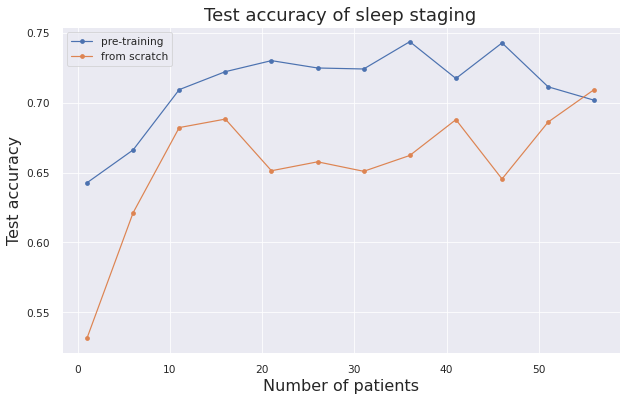

In [51]:
plt.figure(figsize=(10,6));
plt.plot(nb_patients, acc_list, marker="o");
plt.plot(nb_patients, acc_list_scratch, marker="o");
plt.xlabel("Number of patients", fontsize=16);
plt.ylabel("Test accuracy", fontsize=16);
plt.legend(['pre-training', 'from scratch'])
plt.title("Test accuracy of sleep staging", fontsize=18);